In [1]:
# imports and configuration

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms.v2 as transforms
from torchvision.datasets import MNIST

# Import course utilities
# If this fails, run Install_and_Clean.ipynb from Lessons/Course_Tools/
try:
    from introdl.utils import get_device, load_results, load_model, summarizer, config_paths_keys
    from introdl.idlmam import train_network
    from introdl.visul import plot_training_metrics, create_image_grid, evaluate_classifier
except ImportError:
    print("❌ introdl package not found! Please run Install_and_Clean.ipynb first:")
    print("   1. Open Lessons/Course_Tools/Install_and_Clean.ipynb")
    print("   2. Run the installation cell")
    print("   3. Restart this notebook's kernel")
    raise

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

✅ Detected environment: Unknown Environment
   Using course root: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776 (from DS776_ROOT_DIR)

📁 Using course root for workspace: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776
DATA_PATH=/mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/data
MODELS_PATH=/mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/models
CACHE_PATH=/mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/downloads
✅ Workspace paths configured for Unknown Environment

✅ Loaded API keys from: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/Lessons/Course_Tools/api_keys.env
   Kept existing environment keys: GEMINI_API_KEY, GROQ_API_KEY, HF_TOKEN, OPENAI_API_KEY, OPENROUTER_API_KEY, TOGETHER_API_KEY, ZOTERO_API_KEY

🔐 API keys/tokens available (excluding placeholders):
  - GEMINI_API_KEY: AIza...
  - GROQ

✅ Logged into Hugging Face Hub.

📦 introdl package version: 1.3

📂 Model Cache Configuration:
   Student models: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/models
   Cached models: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/downloads
   - PyTorch models: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/downloads/hub
   - HuggingFace models: /mnt/e/GDrive_baggett.jeff/Teaching/Classes_current/2025-2026_Fall_DS776/DS776/downloads/huggingface
   💡 Run Install_and_Clean.ipynb to manage cache space


## Compute Servers in CoCalc

Before diving into this lesson, watch the video below about using compute servers in CoCalc.  A compute server is a separate computer in the cloud that has additional computational resources (a GPU in this case) that we need for deep learning.

#### L02_Compute_Servers Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l02_compute_servers/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l02_compute_servers/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/KM2gteqORkN" target="_blank">Open Descript version of video in new tab</a>

# MNIST Handwritten Digit Classification

## MNIST Handwritten Digits

#### L02_1_MNIST_Dataset Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l02_1_mnist_dataset/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l02_1_mnist_dataset/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/PBBUam1baoL" target="_blank">Open Descript version of video in new tab</a>

<hr>

* 70,000 handwritten digits (0-9). 
* Modified National Institute of Standards and Technology dataset.
* Compiled by **Yann LeCun**, Corinna Cortes, and Christopher J.C. Burges.
* First application of Convolutional Neural Networks.  [Original 1998 paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)

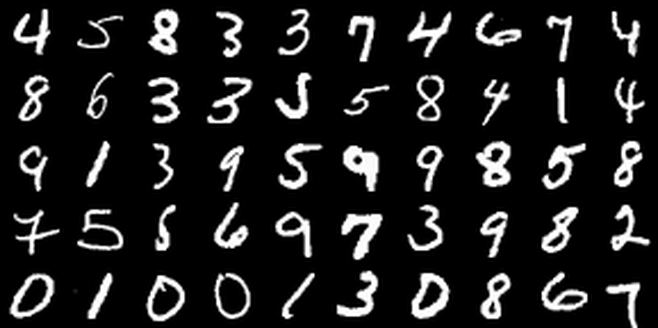

In [2]:
# Load the MNIST dataset
mnist_dataset = MNIST(root=DATA_PATH, train=True, download=True)

# Display a grid of MNIST digits
create_image_grid(mnist_dataset, 5, 10, cmap='gray', dark_mode=True)


The background in grayscale images is usually represented by zeros which are often interpreted as black in grayscale colormaps.  If you would prefer to have the digits look like they are drawn on paper you can choose a reversed colormap:

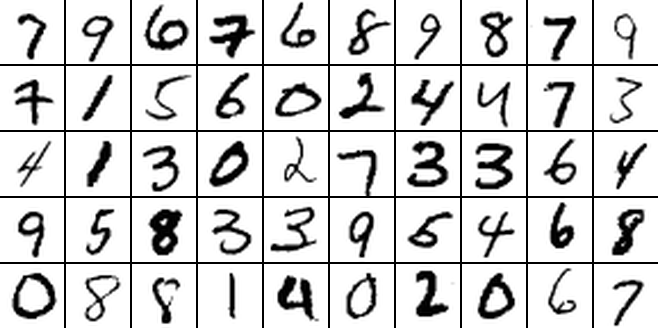

In [3]:
create_image_grid(mnist_dataset, 5, 10, cmap='Greys', dark_mode=True)

Note:  the `create_image_grid` function is a helper function that plots a grid of randomly selected images from a PyTorch dataset.  If you want to see particular images you can pass a list of indices.

## Image Data

In [4]:
# Load the MNIST dataset
mnist_dataset = MNIST(root=DATA_PATH, train=True, download=True)

# Get an image (you can choose any image)
image, label = mnist_dataset[7]

# Convert the PIL image to a NumPy array
image_np = np.array(image)

# Select a portion of the image (e.g., rows 10 to 40 and columns 10 to 40)
df = pd.DataFrame(image_np[4:26,4:24])

# Apply styling to the DataFrame
styled_df = df.style.set_properties(**{
    'font-size': '8pt', 
    'border-collapse': 'collapse',
    'border': '1px solid black',
    'height': '22px',
    'width': '22px'
}).background_gradient(cmap='gray').set_table_styles([
    {'selector': 'td', 'props': [('border', '1px solid black')]}
]).hide(axis='index').hide(axis='columns')

# Display the styled DataFrame
display(styled_df)


0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,38,43,105,255,253,253,253,253,253,174,6,0,0
0,0,0,0,0,43,139,224,226,252,253,252,252,252,252,252,252,158,14,0
0,0,0,0,0,178,252,252,252,252,253,252,252,252,252,252,252,252,59,0
0,0,0,0,0,109,252,252,230,132,133,132,132,189,252,252,252,252,59,0
0,0,0,0,0,4,29,29,24,0,0,0,0,14,226,252,252,172,7,0
0,0,0,0,0,0,0,0,0,0,0,0,0,85,243,252,252,144,0,0
0,0,0,0,0,0,0,0,0,0,0,0,88,189,252,252,252,14,0,0
0,0,0,0,0,0,0,0,0,0,91,212,247,252,252,252,204,9,0,0
0,0,0,0,0,32,125,193,193,193,253,252,252,252,238,102,28,0,0,0
0,0,0,0,45,222,252,252,252,252,253,252,252,252,177,0,0,0,0,0


## The PyTorch MNIST Dataset

In the previous slide we loaded the MNIST dataset with this code:

```python
mnist_dataset = MNIST(root=data_dir, train=True, download=True)
```

The dataset object is an iterable that takes an index and returns an image and a label:

In [5]:
image, label = mnist_dataset[7]
type(image), type(label)

(PIL.Image.Image, int)

In [6]:
image


## Normalizing Pixel Values

- **Normalization** scales the pixel values to a desired range.

### Why Normalize?
- **Improves model performance** by speeding up convergence.
- Helps the model **handle features at different scales**.

### Common Methods:

We'll show how to do these using `torchvision.transforms.v2`. 

1. **Scaling to [0, 1]**:
   - Convert to an image tensor, change the type to floats, and rescale:
     ```python
     transforms.ToImage(),                             # Convert to tensor without scaling
     transforms.ToDtype(torch.float32, scale = True),  # Scale to [0,1]
     ```

2. **Normalizing to mean 0 and std 1**:
   - This further centers the data with mean **0** and standard deviation **1**:
     ```python
     transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
     ```

## Setup the data

In [7]:
mean = (0.1307,)
std = (0.3081,)

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToImage(),                             # Convert to tensor without scaling
    transforms.ToDtype(torch.float32, scale = True),  # Scale to [0,1]
    transforms.Normalize(mean, std)        # Normalize with mean and std of MNIST dataset
])

# Download and load the training dataset 
train_dataset = MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

# Download and load the test dataset
test_dataset = MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False, num_workers=4)

In [8]:
x,y=next(iter(train_loader))
x.shape

torch.Size([64, 1, 28, 28])

## Define the model

#### L02_1_MNIST_FC_Model Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l02_1_mnist_fc_model/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l02_1_mnist_fc_model/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/M9TdvAP64pa" target="_blank">Open Descript version of video in new tab</a>

<hr>

In [9]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),             # Flatten the input image to a vector
            nn.Linear(28 * 28, 128),  # Fully connected layer (28x28 pixels -> 128 hidden units)
            nn.ReLU(),                # Apply ReLU activation function
            nn.Linear(128, 64),       # Fully connected layer (128 hidden units -> 64 hidden units)
            nn.ReLU(),                # Apply ReLU activation function
            nn.Linear(64, 10)         # Hidden layer -> output layer (10 classes)
            #nn.Softmax(dim=1)        # Convert logits to "probabilities" - in CE Loss function
            )
    
    def forward(self, x):
        return self.net(x)

# Initialize the model
model = FullyConnectedNN()

## Model Summary

In [10]:
summarizer(model, input_size = (64,1,28,28) )

Layer (type (var_name))                  Input Shape          Output Shape         Param #
FullyConnectedNN (FullyConnectedNN)      [64, 1, 28, 28]      [64, 10]             --
├─Sequential (net)                       [64, 1, 28, 28]      [64, 10]             --
│    └─Flatten (0)                       [64, 1, 28, 28]      [64, 784]            --
│    └─Linear (1)                        [64, 784]            [64, 128]            100,480
│    └─ReLU (2)                          [64, 128]            [64, 128]            --
│    └─Linear (3)                        [64, 128]            [64, 64]             8,256
│    └─ReLU (4)                          [64, 64]             [64, 64]             --
│    └─Linear (5)                        [64, 64]             [64, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 7.00
Input size (MB): 0.20
Forward/backward pass size (MB): 0.10
Params size (MB): 0.44
Estimated Total Size (MB): 0.74

## Define the model - version 2

In [11]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer (28x28 pixels) -> hidden layer
        self.fc2 = nn.Linear(128, 64)       # Hidden layer -> another hidden layer
        self.fc3 = nn.Linear(64, 10)        # Hidden layer -> output layer (10 classes)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image to a vector
        x = F.relu(self.fc1(x))   # Apply ReLU activation function
        x = F.relu(self.fc2(x))   # Apply ReLU activation function
        x = self.fc3(x)           # Output layer (logits)
        return x

# Initialize the model
model = FullyConnectedNN()

## Setup training

We're going to cheat a bit here and use a variant of gradient descent called the AdamW optimizer.  We'll talk more about optimizers in lesson 3, but it would be a shame to wait until then to use it because it's much more efficient than vanilla gradient descent.

In [12]:
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters())  # AdamW optimizer, default lr=0.001

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L02_MNIST_FC.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

cpu


## Train

In [13]:
results_MNIST_FC = train_network(model,
                                 loss_func,
                                 train_loader,
                                 device=device,
                                 test_loader=test_loader,
                                 epochs = epochs,
                                 optimizer = optimizer,
                                 score_funcs = score_funcs,
                                 checkpoint_file=ckpt_file,
                                 pretend_train=True)

Pretend Training:   0%|          | 0/10 [00:00<?, ?it/s]

## Results

We get 97% to 98% accuracy on the validation set after only a few epochs!

In [14]:
ckpt_file = MODELS_PATH / 'L02_MNIST_FC.pt'
results_MNIST_FC = load_results(ckpt_file)

results_MNIST_FC

,epoch,total time,train loss,test loss,train ACC,test ACC
0,0,3.892178,0.266190,0.144889,0.920500,0.9521
1,1,9.872958,0.110924,0.098405,0.965717,0.9701
2,2,13.992884,0.078214,0.085974,0.975267,0.9737
3,3,19.911982,0.059195,0.094972,0.980817,0.9719
4,4,26.289169,0.048701,0.088124,0.984200,0.9743
5,5,32.835480,0.041054,0.109555,0.985950,0.9684
6,6,39.136235,0.032500,0.080146,0.989100,0.9779
7,7,45.448108,0.030685,0.101944,0.989367,0.9723
8,8,51.645828,0.025196,0.102991,0.991633,0.9714
9,9,57.942773,0.020431,0.084355,0.993217,0.9779


You can also view the results graphically if you would prefer.

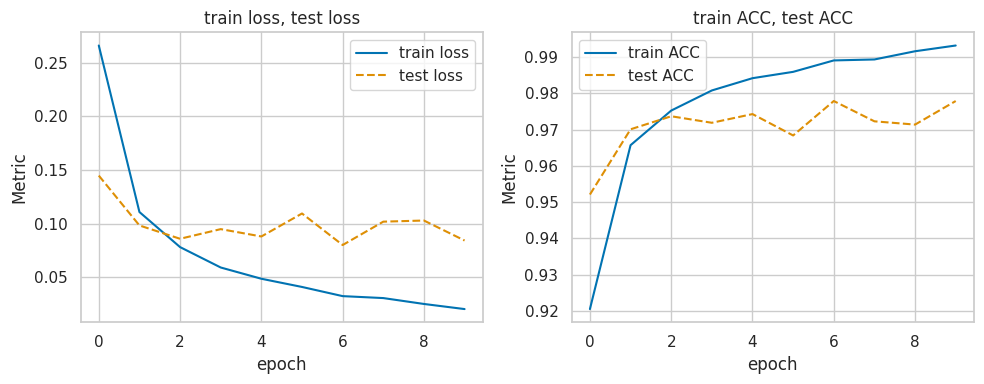

In [15]:
plot_training_metrics(results_MNIST_FC, [['train loss', 'test loss'], ['train ACC', 'test ACC']])

After epoch 2 (the third epoch, silly Python indexing ...) there is some evidence of mild overfitting since the training loss continues to decrease while the test loss remains constant.  This indicates that the network is memorizing details of the training set instead of learning to generalize.  Though it's pretty amazing that we have greater than 97% accuracy on the test set without much effort!

We could simply stop the training after the third epoch.  We'll see more about dealing with overfitting in the next lesson.

### Evaluating the Model

#### L02_1_MNIST_FC_Evaluation Video

<iframe 
    src="https://media.uwex.edu/content/ds/ds776/ds776_l02_1_mnist_fc_evaluation/" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="https://media.uwex.edu/content/ds/ds776/ds776_l02_1_mnist_fc_evaluation/" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/U8URO7JMabR" target="_blank">Open Descript version of video in new tab</a>

<hr>

Greater than 97% accuracy is pretty amazing for our first effort.  Whenever you're working on a model it's important to understand the instances that the model predicts incorrectly.  Sometimes this gives insight into how the model can be improved.

The code below shows how to loop over the test dataset and collect all the labels, predictions, and misclassified images. It also displays the confusion matrix.  Inspect the confusion matrix to look for common errors.  For example nines are frequently misclassified as fours.

Total number of images: 10000
Number of misclassified images: 221


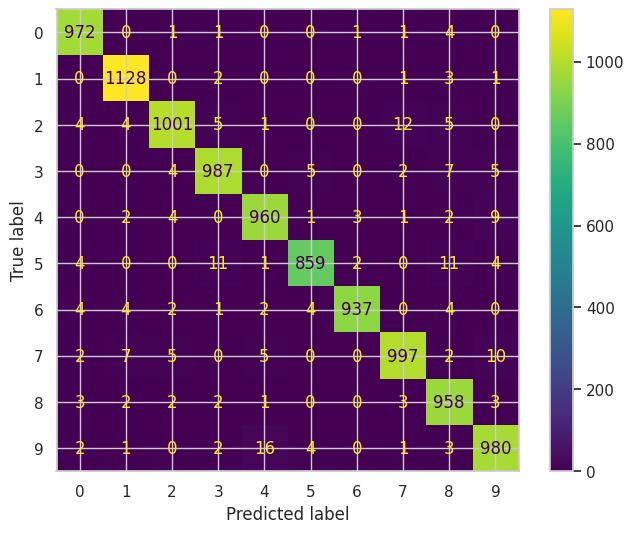

In [16]:
device = get_device()
model = load_model(FullyConnectedNN, MODELS_PATH / 'L02_MNIST_FC.pt', device)

# Set the model to evaluation mode
model.eval()

# Collect the labels, predicted labels, and misclassified images
labels = []
pred_labels = []
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate over the test dataset
for images, targets in test_loader:
    # Move the images and targets to the device
    images = images.to(device)
    targets = targets.to(device)
    
    # Forward pass
    outputs = model(images)
    
    # Get the predicted labels
    _, predicted = torch.max(outputs.data, 1)
    
    # Append the labels and predicted labels to the lists
    labels.extend(targets.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
    
    # Collect misclassified images
    for i in range(len(targets)):
        if targets[i] != predicted[i]:
            misclassified_images.append(images[i].cpu().numpy())
            misclassified_true_labels.append(targets[i].item())
            misclassified_pred_labels.append(predicted[i].item())

# Print the total number of images and the number of misclassified images
total_images = len(labels)
num_misclassified = len(misclassified_images)
print(f'Total number of images: {total_images}')
print(f'Number of misclassified images: {num_misclassified}')

# Compute the confusion matrix
confusion_mat = confusion_matrix(labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_mat)
disp.plot()
plt.show()

It's a good idea to look at the images that are misclassified.  Running the cell below will display 25 misclassified digits selected at random.  Are you surprised by any of the misclassifications? Run the cell repeatedly to see different samples of misclassified digits.

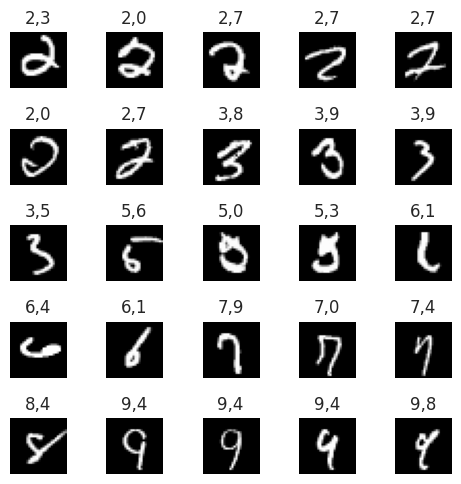

In [17]:
# Plot a random sample of 25 misclassified images (or fewer if there aren't 25), ordered by true label
num_images_to_plot = min(25, num_misclassified)
random_indices = np.random.choice(num_misclassified, num_images_to_plot, replace=False)

# Sort the selected misclassified images by their true labels
sorted_indices = sorted(random_indices, key=lambda i: misclassified_true_labels[i])

num_cols = 5
num_rows = (num_images_to_plot + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, num_rows))
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < num_images_to_plot:
        idx = sorted_indices[i]
        image = misclassified_images[idx].squeeze()  # Remove channel dimension if present
        true_label = misclassified_true_labels[idx]
        pred_label = misclassified_pred_labels[idx]
        
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'{true_label},{pred_label}')
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

### Helper functions for evaluating classification models

Instead of having to write all that code to evaluate a model and visualize the misclassifications, we've 

To make it simpler to evaluate a classification model we wrote a helper function called `introdl.utils.evaluate_classifier`.  To illustrate we'll show how to use it to evaluate our fully-connected model trained on MNIST.

The dataset has 10000 samples.
The model misclassified 221 samples.


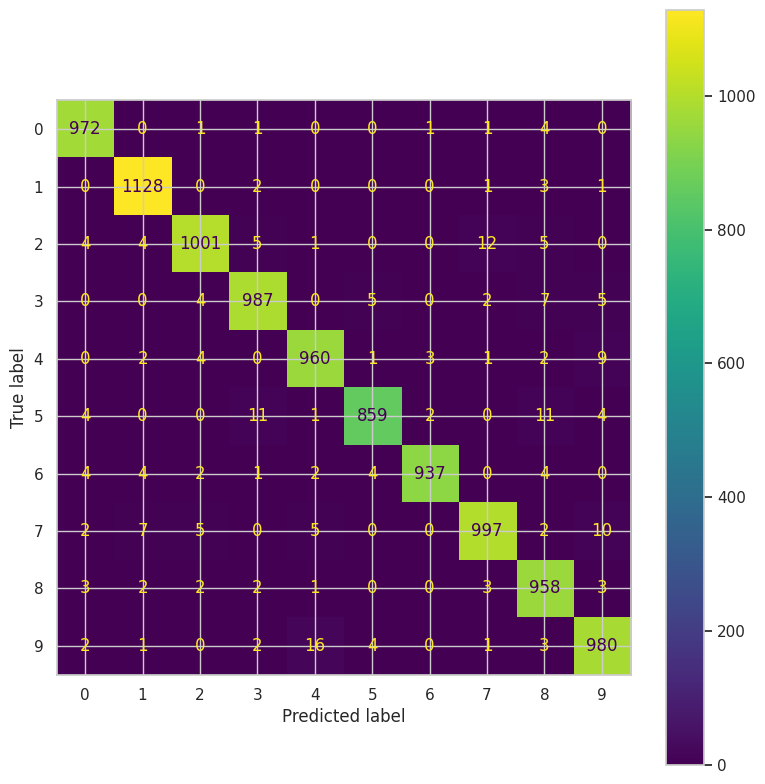

In [18]:
model = load_model(FullyConnectedNN(), MODELS_PATH / 'L02_MNIST_FC.pt')
device = get_device()
conf_mat,report,missed_dataset=evaluate_classifier(model, test_dataset, device, img_size=(8,8),use_class_labels=False)

The `evaluate_classifier` also returns a classification report generated by `scikit-learn` package.

In [19]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.96      0.97       892
           6       0.99      0.98      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Finally, it returns a dataset with the images that were mispredicted by the classifer and customized labels.  We can use it to make quick visulizations of the misclassified images.

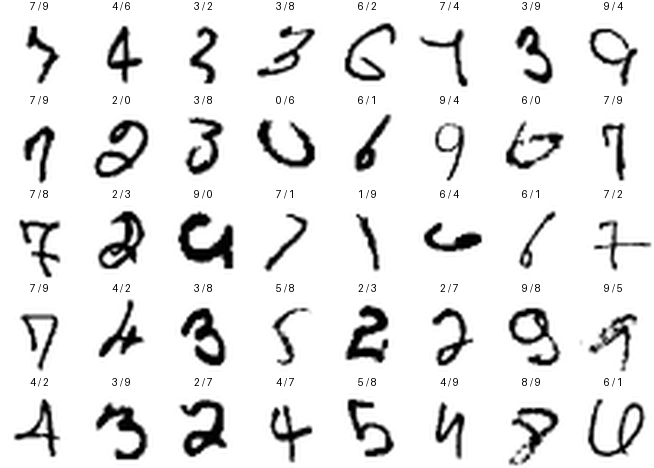

In [20]:
create_image_grid(missed_dataset, nrows=5, ncols=8, img_size=(80,80), show_labels=True, 
                  cmap='Greys', mean=.1307, std=.3081, dark_mode=False)